In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import timeit
import statistics
import time
import torch
import torch_geometric
import importlib

from data_utils import synthetic_data
from data_utils import graph_constructors

import networkx as nx

import importlib

In [2]:
importlib.reload(synthetic_data)
importlib.reload(graph_constructors)

<module 'data_utils.graph_constructors' from '/home/a/Documents/GNN-for-trans-grouping/GNN-for-trans-grouping/data_utils/graph_constructors.py'>

In [3]:
%timeit synthetic_data.make_a_group()

727 µs ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


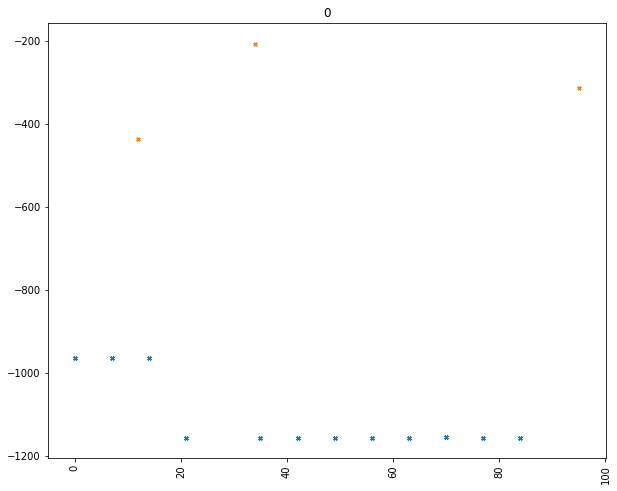

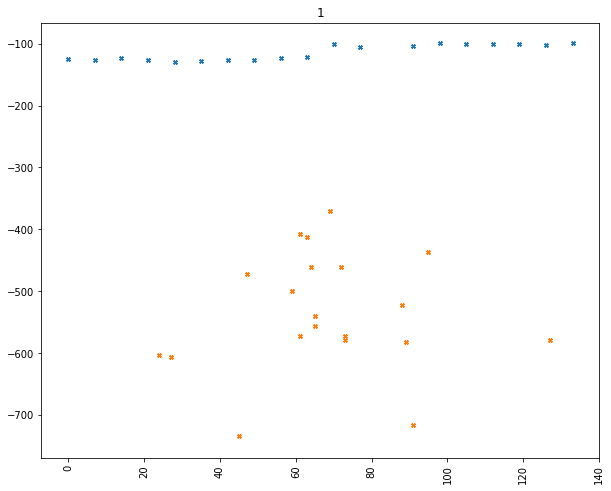

In [4]:
colour_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for i in range(2):
    d_lst, a_lst, g_lst = synthetic_data.make_a_group()
    
    d_arr = np.array(d_lst)
    a_arr = np.array(a_lst)
    g_arr = np.array(g_lst)    
    
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10,8), sharex=True)
    for g in g_lst:
        mask = (g_arr == g)
        
        ax1.scatter(d_arr[mask], a_arr[mask], s=10, c=colour_list[g%10], marker='x')
        ax1.set_title(str(i))
        #ax1.legend(loc="upper right")
    
    for ax1 in fig.axes:
        matplotlib.pyplot.sca(ax1)
        plt.xticks(rotation=90)
        #plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    
    plt.show

In [5]:
d_lst, a_lst, g_lst = synthetic_data.make_a_group()

In [6]:
d_arr = np.array(d_lst)
a_arr = np.array(a_lst)
g_arr = np.array(g_lst)

In [7]:
norm_a_arr = graph_constructors.normalise_amounts(a_arr)

In [147]:
edge_lst, edge_features_lst, edge_labels_lst = graph_constructors.find_nearest_in_interval(inp_day_arr = d_arr
                         , inp_norm_amt_arr = norm_a_arr
                         , inp_group_arr = g_arr
                         , cur_edge_lst =[]
                         , cur_edge_features_lst = []
                         , cur_edge_labels_lst = []
                         , interval = np.array([5,9]))

In [148]:
edge_lst, edge_features_lst, edge_labels_lst = graph_constructors.find_nearest_amount(inp_day_arr = d_arr
                         , inp_norm_amt_arr = norm_a_arr
                         , inp_group_arr = g_arr
                         , cur_edge_lst =[]
                         , cur_edge_features_lst = []
                         , cur_edge_labels_lst = [])

edge_lst

[[0, 1],
 [1, 0],
 [1, 2],
 [2, 1],
 [2, 3],
 [3, 2],
 [3, 4],
 [4, 3],
 [4, 5],
 [5, 4],
 [5, 7],
 [7, 5],
 [7, 6],
 [6, 7]]

In [ ]:
edge_lst, edge_features_lst, edge_labels_lst = graph_constructors.find_nearest_day(inp_day_arr = d_arr
                         , inp_norm_amt_arr = norm_a_arr
                         , inp_group_arr = g_arr
                         , cur_edge_lst =[]
                         , cur_edge_features_lst = []
                         , cur_edge_labels_lst = [])

In [8]:
data = graph_constructors.make_pyg_graph(d_arr, a_arr, g_arr)

In [9]:
node_ids = [x for x in range(len(d_arr))]
positions_list = [(x[0], x[1]) for x in data['pos'].tolist()]
pos_dict = dict(zip(node_ids, positions_list))

In [10]:
g = torch_geometric.utils.to_networkx(data, node_attrs=None, edge_attrs=None)

/home/a/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/a/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


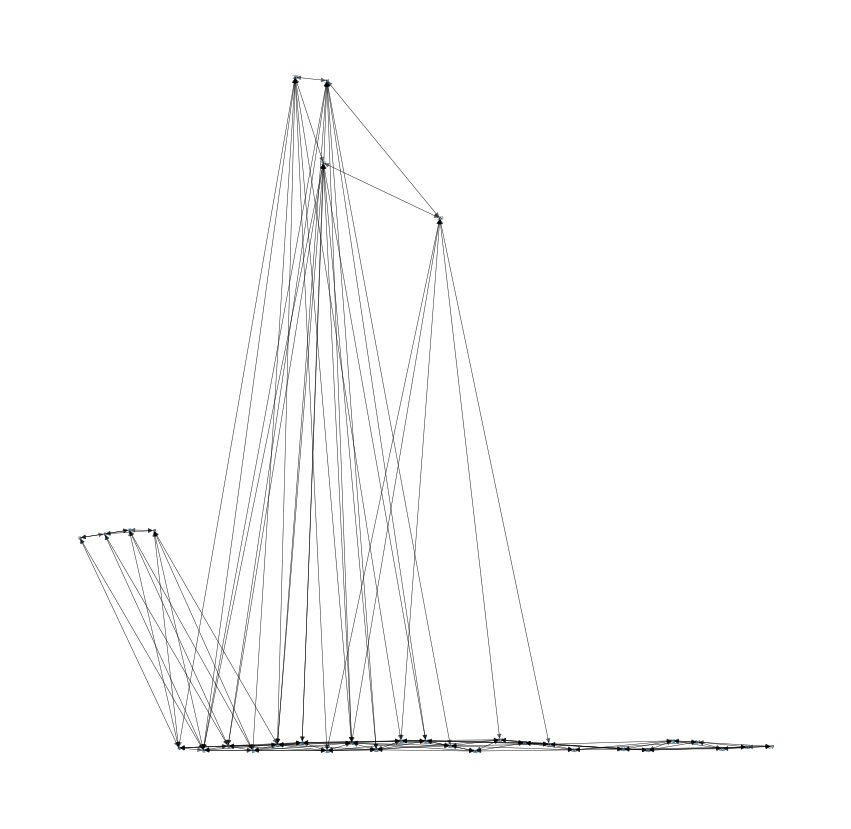

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
nx.draw_networkx(g, ax=ax, node_size=5,
                 font_size=6, alpha=.5,
                 width=.5, pos = pos_dict)
ax.set_axis_off()

### Set up the model

First construct the dataloader

In [ ]:
#initial model structure

#1.embedding on the edge_attr to a lower dim space using a MLP
#2.edge to node convolution - might need to hand code class
#3.node to edge convolution - probably already exists in PyG
#4.repeat above (same convolutions or new ones?)
#5.MLP on new edge_attrs
#6.softmax on MLP output

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import ECConv

from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean
from torch_geometric.nn import MetaLayer
from torch_geometric.data import Data, DataLoader
import torch.nn as nn

In [157]:
importlib.reload(synthetic_data)
importlib.reload(graph_constructors)

<module 'data_utils.graph_constructors' from 'C:\\Users\\andy.knapper\\Documents\\OW\\Categorisation\\ML grouping\\GNN-for-trans-grouping\\data_utils\\graph_constructors.py'>

#### Below is model that I want to implement

https://github.com/rusty1s/pytorch_geometric/issues/535

Things I can vary:

1. Graph construction / pruning  (e.g. bi-directional or not)
2. Embedding network and dimensions
3. convolution direction to start with (node->edge or edge->node)
4. node convolution structure (retain initial features in attr tensor)
5. edge convolution structure (retain initial features in attr tensor)
6. classification network - how to combine the edge attrs if the graph is bidirectional
7. loss criteria - unbalanaced classes, should this be weighted for certain types of mis-classification
8. training tricks: batch normalisation, dropout, initialisation

Ideas:

* simplify the combination of groups in each example
* recode graph generation to only have edges in one direction (make the amount edge property an abs value)
* prune the edges from the graphs to make them more sparse
* recode the node attr update conv to use only the single directional edge but treat src and dest symmetrically (model code on current edge attr update conv)
* make sure the MLP are deep enough and add batch norm and drop out
* include multiple iterations of update using differnt convolutions at each stage


In [13]:
##############################################################################
#first create the class to perform the node->edge convolutions
#this will be called later in the overall model

class MyLayer(torch.nn.Module):
    def __init__(self, number_of_node_features, number_of_edge_features):
        super(MyLayer, self).__init__()

        edge_mlp_channels_in = 2 * number_of_node_features + 10
        #only one layer deep at present
        self.edge_mlp = Seq(Lin(edge_mlp_channels_in, 10), ReLU())

        
        def edge_model(src, dest, edge_attr, u, batch):
            edge_neighborhoods = torch.cat([src, dest, edge_attr], 1)
            return self.edge_mlp(edge_neighborhoods)

        self.op = MetaLayer(edge_model)

    def forward(self, x, edge_index, edge_attr, u, batch):
        return self.op(x, edge_index, edge_attr, u, batch)

In [14]:
class Net(torch.nn.Module):
    def __init__(self, number_of_node_features, number_of_edge_features):
        super(Net, self).__init__()

        self.number_of_node_features = number_of_node_features
        self.number_of_edge_features = number_of_edge_features
        
        #initialise edge embedding MLP
        self.edge_embed_lin1 = Lin(self.number_of_edge_features, 20)
        self.edge_embed_lin2 = Lin(20, 10)
        self.edge_embed_act1 = ReLU()
        self.edge_embed_act2 = ReLU()
        
        #self.edge_embed_mlp = Seq(self.edge_embed_lin1, nn.BatchNorm1d(20), self.edge_embed_act1, self.edge_embed_lin2, nn.BatchNorm1d(10), self.edge_embed_act2)
        self.edge_embed_mlp = Seq(self.edge_embed_lin1, self.edge_embed_act1, self.edge_embed_lin2,  self.edge_embed_act2)
        
        #initialise edge conditioned convolution to update node attributes by propagating surrounding node attributes via edge attributes
#         self.node_update_conv_nn = Seq(Lin(10, 5),
#                                        nn.BatchNorm1d(5),
#                                                  ReLU(), 
#                                                  Lin(5, self.number_of_node_features*self.number_of_node_features),
#                                                  nn.BatchNorm1d(self.number_of_node_features*self.number_of_node_features),
#                                                  ReLU())

        self.node_update_conv_nn = Seq(Lin(10, 5),
                                                 ReLU(), 
                                                 Lin(5, self.number_of_node_features*self.number_of_node_features),
                                                 ReLU())
        
        
        self.node_update_conv = ECConv(in_channels = self.number_of_node_features,
                                       out_channels=self.number_of_node_features, 
                                       nn = self.node_update_conv_nn, 
                                       aggr='add', 
                                       root_weight=True, 
                                       bias=True)
        
        #initialise the edge_attr updates from the node attrs
        #self.meta_layer = MyLayer(number_of_node_features, number_of_edge_features)
        self.meta_layer = MyLayer(number_of_node_features, 10)
        
        
        
        
        #we are trying to use the same classifier on both edge direction to get the same answer
        #this won't work!
        
        
        #initialise edge classifier MLP
        self.edge_class_lin1 = Lin(10, 5)
        self.edge_class_lin2 = Lin(5, 2)
        self.edge_class_act1 = ReLU()
        self.edge_class_act2 = ReLU()
        
        self.edge_class_mlp = Seq(self.edge_class_lin1, self.edge_class_act1, self.edge_class_lin2,  self.edge_class_act2)
        
        

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        #embed the edge attributes in a lower dim space      
        edge_attr = self.edge_embed_mlp(edge_attr)

        #update the node attributes
        x = self.node_update_conv(x, edge_index, edge_attr)
        
        #update the edges attributes
        x, edge_attr, _ = self.meta_layer.forward(x, edge_index, edge_attr, u=None, batch=data.batch)
                     
        #apply a classifier to the edge attrs
        edge_attr = self.edge_class_mlp(edge_attr)

        return F.log_softmax(edge_attr, dim=1)

    


In [15]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


create the dataloader and iterate the data through the model

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [17]:
data_list = [graph_constructors.make_pyg_graph(*np.array(synthetic_data.make_a_group())).to(device) for _ in range(32)]
loader = DataLoader(data_list, batch_size=8)

In [18]:
node_features = data_list[0].x.shape[-1]
num_edges = data_list[0].edge_attr.shape[0]
edge_features = data_list[0].edge_attr.shape[-1]

In [19]:
model = Net(node_features, edge_features)

model.apply(init_weights)

print('Let\'s use', torch.cuda.device_count(), 'GPU(s)!')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for j in range(1000):
    
    #print(j)
    
    data_list = [graph_constructors.make_pyg_graph(*np.array(synthetic_data.make_a_group())).to(device) for _ in range(1024)]
    loader = DataLoader(data_list, batch_size=8)

    for i, btch in enumerate(loader):

        optimizer.zero_grad()
        output = model(btch)

        y = btch.y.to(output.device)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
    
    print('loss at iteration ', j ,' is ', loss)

    

/home/a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Let's use 2 GPU(s)!


ValueError: Expected input batch_size (3178) to match target batch_size (1589).

In [59]:
np.isscalar(np.array([5]))

False

In [63]:
np.expand_dims(5, axis = 0)

array([5])

In [93]:
for _ in range(10000):
    graph_constructors.make_pyg_graph(*np.array(synthetic_data.make_a_group()))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [92]:
graph_constructors.make_pyg_graph(*np.array(synthetic_data.make_a_group()))

Data(edge_attr=[374, 93], edge_index=[2, 374], pos=[53, 2], x=[53, 1], y=[374])

In [48]:
inp_norm_amt_arr = np.array([])
sort_idx = np.argsort(inp_norm_amt_arr)
sorted_norm_amt_arr = inp_norm_amt_arr[sort_idx]
sorted_norm_amt_arr

array([], dtype=float64)

In [47]:
inp_norm_amt_arr.shape

(1,)

In [24]:
torch.tensor([1.2999]).long()

tensor([1])

### Instructive examples

Below is an example of someone using a metalayer.  Take this example and apply it to a known data set to see how the edge model extracts the src and dest objects and what form they take.  We can then us this knowledge to create the edge_model that we want.

In [ ]:
from torch_geometric.datasets import MNISTSuperpixels

dataset = MNISTSuperpixels('/data', 'MNIST')

In [ ]:
dataset = MNISTSuperpixels('/data', 'MNIST', transform=T.Cartesian()).shuffle()

In [ ]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.data import DataListLoader
import torch_geometric.transforms as T
from torch_geometric.nn import SplineConv, global_mean_pool, DataParallel, MetaLayer

# path = osp.join(osp.dirname(osp.realpath(__file__)), '../', 'data', 'MNIST')
# dataset = MNISTSuperpixels(path, transform=T.Cartesian()).shuffle()
loader = DataListLoader(dataset, batch_size=1, shuffle=False)

class MyLayer(torch.nn.Module):
    def __init__(self, number_of_node_features, number_of_edge_features):
        super(MyLayer, self).__init__()

        edge_mlp_channels_in = 2 * number_of_node_features + number_of_edge_features
        self.edge_mlp = Seq(Lin(edge_mlp_channels_in, number_of_edge_features),
                            ReLU())

        def edge_model(src, dest, edge_attr, u, batch):
            print('called edge_model')
            print('src.shape', src.shape)            
            print('src', src)
            print(' ')
            print('dest.shape', dest.shape)   
            print('dest', dest)
            edge_neighborhoods = torch.cat([src, dest, edge_attr], 1)
            print('edge_neighborhoods.shape', edge_neighborhoods.shape)
            
            my_string = "edge_neighborhoods.device\n" + str(edge_neighborhoods.device) + "\nself.edge_mlp[0].weight.device\n" + str(self.edge_mlp[0].weight.device)
            print(my_string)

            return self.edge_mlp(edge_neighborhoods)

        self.op = MetaLayer(edge_model)

    def forward(self, x, edge_index, edge_attr, u, batch):
        return self.op(x, edge_index, edge_attr, u, batch)

class Net(torch.nn.Module):
    def __init__(self, number_of_node_features, number_of_edge_features):
        super(Net, self).__init__()
        self.meta_layer = MyLayer(number_of_node_features, number_of_edge_features)
        self.conv1 = SplineConv(dataset.num_features, 32, dim=2, kernel_size=5)
        self.conv2 = SplineConv(32, 64, dim=2, kernel_size=5)
        self.lin1 = torch.nn.Linear(64, 128)
        self.lin2 = torch.nn.Linear(128, dataset.num_classes)

    def forward(self, data):
        print('Inside Model:  num graphs: {}, device: {}'.format(
            data.num_graphs, data.batch.device))

        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x, edge_attr, _ = self.meta_layer.forward(x, edge_index, edge_attr, u=None, batch=data.batch)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = global_mean_pool(x, data.batch)
        x = F.elu(self.lin1(x))
        return F.log_softmax(self.lin2(x), dim=1)


node_features = dataset[0].x.shape[-1]
edge_features = dataset[0].edge_attr.shape[-1]
model = Net(node_features, edge_features)
print('Let\'s use', torch.cuda.device_count(), 'GPUs!')
model = DataParallel(model)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for i, data_list in enumerate(loader):
    print('x.shape', data_list[0].x.shape)
    print('x:', data_list[0].x)
    print('')
    print('edge_attr.shape', data_list[0].edge_attr.shape)    
    print('edge_attr', data_list[0].edge_attr)
    print('')    

    optimizer.zero_grad()
    output = model(data_list)
    print('Outside Model: num graphs: {}'.format(output.size(0)))
    print([data.y for data in data_list])
    y = torch.cat([data.y for data in data_list]).to(output.device)
    loss = F.nll_loss(output, y)
    loss.backward()
    optimizer.step()
    if i > 0:
        break 
    

In [ ]:
loader = DataListLoader(dataset, batch_size=4, shuffle=False)
len(loader)

In [ ]:
node_features = data.x.shape[-1]
edge_features = data.edge_attr.shape[-1]

model = Net(node_features, edge_features)
print('Let\'s use', torch.cuda.device_count(), 'GPUs!')
model = DataParallel(model)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for i, data_list in enumerate(loader):
    if i > 0:
        break
    optimizer.zero_grad()
    output = model(data_list)



In [ ]:
MyLayer.forward(x=dataset[0].x, edge_index=dataset[0].edge_index, edge_attr=dataset[0].edge_attr, u = None, batch = None)

In [ ]:
data_list = [data, data]

In [ ]:
class MyLayer(torch.nn.Module):
    def __init__(self, number_of_node_features, number_of_edge_features):
        super(MyLayer, self).__init__()

        edge_mlp_channels_in = 2 * number_of_node_features + number_of_edge_features
        self.edge_mlp = Seq(Lin(edge_mlp_channels_in, number_of_edge_features),
                            ReLU())

        def edge_model(src, dest, edge_attr, u, batch):
            edge_neighborhoods = torch.cat([src, dest, edge_attr], 1)
            my_string = "edge_neighborhoods.device\n" + str(edge_neighborhoods.device) + "\nself.edge_mlp[0].weight.device\n" + str(self.edge_mlp[0].weight.device)
            print(my_string)

            return self.edge_mlp(edge_neighborhoods)

        self.op = MetaLayer(edge_model)

    def forward(self, x, edge_index, edge_attr, u, batch):
        return self.op(x, edge_index, edge_attr, u, batch)

class Net(torch.nn.Module):
    def __init__(self, number_of_node_features, number_of_edge_features):
        super(Net, self).__init__()
        self.meta_layer = MyLayer(number_of_node_features, number_of_edge_features)
        #self.conv1 = SplineConv(dataset.num_features, 32, dim=2, kernel_size=5)
        self.conv1 = SplineConv(number_of_node_features, 32, dim=2, kernel_size=5)
        self.conv2 = SplineConv(32, 64, dim=2, kernel_size=5)
        self.lin1 = torch.nn.Linear(64, 128)
        self.lin2 = torch.nn.Linear(128, 2)

    def forward(self, data):
#         print('Inside Model:  num graphs: {}, device: {}'.format(
#             data.num_graphs, data.batch.device))

        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        #x, edge_attr, _ = self.meta_layer.forward(x, edge_index, edge_attr, u=None, batch=data.batch)
        x, edge_attr, _ = self.meta_layer.forward(x, edge_index, edge_attr, u=None, batch=[1])
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = global_mean_pool(x, data.batch)
        x = F.elu(self.lin1(x))
        return F.log_softmax(self.lin2(x), dim=1)

In [ ]:
model = Net(node_features, edge_features)

In [ ]:
model(data)

In [ ]:
from torch_geometric.data import Data, DataLoader

data_list = [data, data]
loader = DataLoader(data_list, batch_size=2)